# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [2]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

    100% |████████████████████████████████| 1.6MB 7.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
Successfully built networkx
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
pomegranate 0.9.0 has requirement networkx<2.0,>=1.8.1, but you'll have networkx 2.1 which is incompatible.
moviepy 0.2.3.2 has requirement decorator==4.0.11, but you'll have decorator 4.4.2 which is incompatible.
jupyterlab-server 1.0.0 has requirement jsonschema>=3.0.1, but you'll have jsonschema 2.6.0 which is incompatible.
ipywidgets 7.0.5 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.1.0 which is incompatible.


In [3]:
nx.__version__ # should be 2.1

'2.1'

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from sklearn.neighbors import KDTree
from queue import PriorityQueue
import networkx as nx
%matplotlib inline

In [77]:
plt.rcParams['figure.figsize'] = 15, 15

## Step 1 - Load Data

In [6]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [70]:
#define the poly class
class Poly:
    def __init__(self,coords,height):
        #define the ploygon with the coordinates in the order
        self._polygon=Polygon(coords)
        self._height=height
        
    @property
    def height(self):
        return self._height
    #extract the points forming the exterior boundary (first and last point are the same drop the last point)
    @property
    def coords(self):
        return list(self._polygon.exterior.coords)[:-1]
    
    @property
    def area(self):
        return self._polygon.area
    
    #return the polygon center
    @property
    def center(self):
        return (self._polygon.centroid.x,self._polygon.centroid.y)
    
    def contains(self,point):
        point=Point(point)
        return self._polygon.contains(point)
    
    def crosses(self,other):
        return self._polygon.crosses(other)
    

In [45]:
#extract the all the polygons from the dataset
def extract_polygons(data):
    polygons=[]
    for i in range(data.shape[0]):
        #iterate throught the data
        north,east,alt,d_north,d_east,d_alt = data[i,:]
        
        #create the coordinates  x=north y=east
        bot_left=(north-d_north , east-d_east)
        bot_right=(north-d_north , east+d_east)
        top_left=(north+d_north , east - d_east)
        top_right=(north+d_north , east+d_east)
        
        #coner order matters
        corners=[bot_left,bot_right,top_right,top_left]
        height = alt+d_alt
        
        p =  Poly(coords=corners,height=height)
        polygons.append(p)
        
    return polygons

In [99]:
#define a sample funtion to sample from the points and output 
class Sampler:
    def __init__(self,data):
        self.polygons=extract_polygons(data)
        self.north_min=np.min(data[:,0] - data[:,3])
        self.north_max=np.max(data[:,0] + data[:,3])
        
        self.east_min=np.min(data[:,1] -  data[:,4])
        self.east_max=np.max(data[:,1] + data[:,4])
        print(self.east_min,self.east_max)
        #define the zmin and zmax because those value depend the drone capabilities
        self.z_min=0
        self.z_max=20
        
        #need to create a KD-tree fro sampling the random samples to obtain the nearest obstacle polygon
        #define a kd-tree with the polygon center
        self.centers=np.array([ p.center  for p in self.polygons])
        #define the kd-tree
        self.kd_tree=KDTree(self.centers,metric='euclidean')
        #define the neigbour radius margin for the reuslts
        #return neigbours with in this radius and this value should be max of d_north or d_east
        self._max_xy=2* np.max((data[:,3],data[:,4]))
        
    def sampling(self,sampels):
        x_vals=np.random.uniform(self.north_min,self.north_max,sampels)
        y_vals=np.random.uniform(self.east_min,self.east_max , sampels)
        z_vals=np.random.uniform(self.z_min,self.z_max,sampels)
        
        random_samples=list(zip(x_vals,y_vals,z_vals))
     
        #check on the random samples with the defined kd-tree
        not_collied=[]
        for sample in random_samples:
        
            #query return the indices of the neigbours
            neighbour_poly=list(self.kd_tree.query_radius(np.array((sample[0],sample[1])).reshape(1,-1) ,r=self._max_xy )[0])

            is_collied=False
            if(len(neighbour_poly) >0 ):
                for poly in neighbour_poly:
                    #return the polygon
                    polygon=self.polygons[poly]
                    #check the polygon conatin this point or not
                    if(polygon.contains(sample[:2]) and polygon.height >= sample[2]):
                        is_collied=True
                        
            if(not is_collied):
                not_collied.append(sample)
                
                
        return not_collied
    
    def _polygons(self):
        return self.polygons
                

In [100]:
# TODO: sample points randomly
sampler=Sampler(data=data)
graph_nodes=sampler.sampling(300)
print(len(graph_nodes))
# then use KDTree to find nearest neighbor polygon
# and test for collision

-444.2315 475.7685
200


In [101]:
print(graph_nodes)

[(221.53367515105316, 106.89582847634972, 13.297682194115641), (-95.045224172183367, -46.055638202358125, 16.64933002590217), (52.857916921502806, -407.38966985607664, 6.6006229922625543), (174.2549551217769, -170.28486353271472, 17.015296177196181), (-314.58256782208696, 222.62551991122575, 0.48758292120274715), (-258.46515535215309, -267.7210930853206, 8.5629323750880619), (20.251083464980638, 248.84372750460648, 8.7907974609055834), (110.62219127814149, -227.16941778217034, 3.6718179337736867), (193.37724379943126, -151.77299876471511, 5.9774522871139224), (61.152610840566069, 5.2475157861044863, 13.215770875296863), (-129.76563771492974, -196.91066975551195, 12.897530481363084), (572.86447102413422, 79.229123562303812, 5.9007045157203564), (389.93452100781423, -164.58860284194623, 5.957626716820501), (474.01555490225479, -407.53298358758212, 11.490442142026886), (429.62464232361623, 115.76723188104995, 17.473946238063757), (-16.48059418159005, -256.97545942158388, 1.907580909823314

In [102]:
polygons=sampler._polygons()

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [103]:
def can_connect(p1,p2):
    line=LineString([p1,p2])
    for p in polygons:
        if(p.crosses(line) and p.height >=min(p1[2],p2[2])):
            return False
    return True

In [104]:
def create_graph(nodes,k):
    #k - how many neigbour should return from the kd-tree
    graph=nx.Graph()
    kd_tree=KDTree(nodes)
    for n in nodes:
        #return the neighbour indices
        neighbours=list(kd_tree.query([n] ,k ,return_distance=False)[0])
        if(len(neighbours)>0):
            for p in neighbours:
                #check on the neigbour is equal to the query point
                if(nodes[p] == n):
                    continue
                else:
                    if(can_connect(n,nodes[p])):
                        graph.add_edge(n,nodes[p],weight=1)
    return graph
                    
    

In [105]:
#take the graph for path planning
result_graph=create_graph(graph_nodes,10)

In [7]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

## Step 4 - Visualize Graph

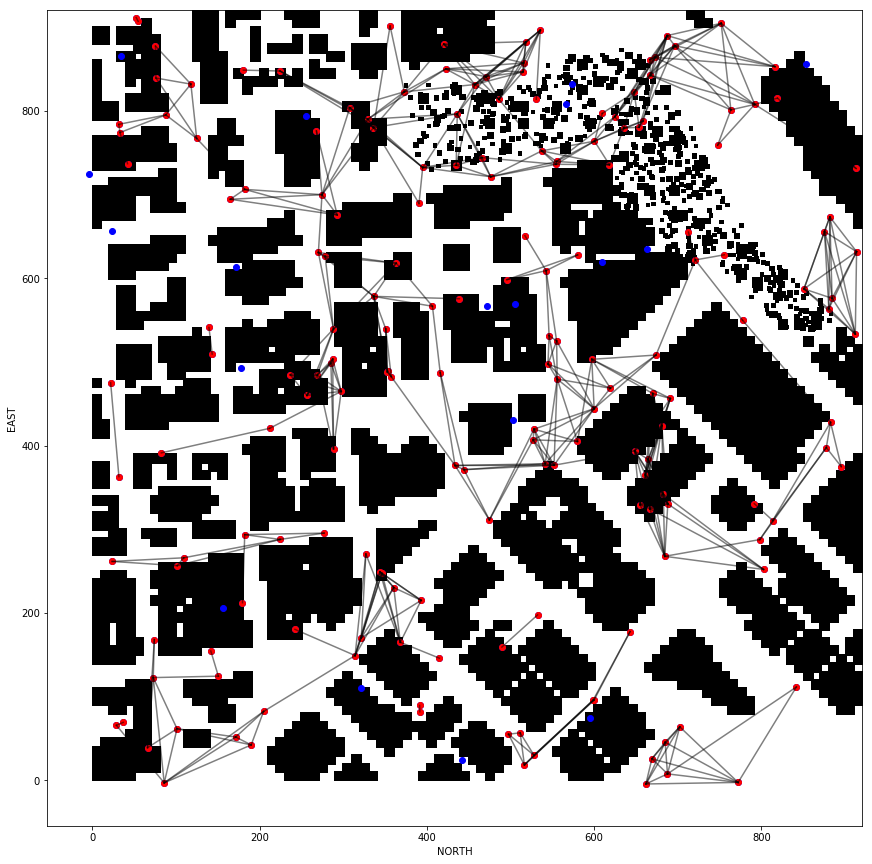

In [106]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in result_graph.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in graph_nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in result_graph.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [107]:
def heuristic(n1, n2):
    cost=np.sqrt((n2[0]-n1[0])**2 + ( n2[1] -n1[1] )**2  +  ( n2[2] - n1[2] )**2  )
    return cost

## Step 6 - Complete A*

In [150]:
from queue import PriorityQueue
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    #keep the next movement point
    q=PriorityQueue()
    q.put((0,start))
    #put the visited nodes
    visited=set()
    visited.add(start)
    #path tracking dictionary
    branch={}
    #iterate since the movemnet list got empty or find the goal
    Found=False
    while not q.empty():
        current_value=q.get()
        current_node=current_value[1]
        current_cost=current_value[0]
        #if the current node is eual to goal the stop the a* algorithm
        if(current_node == goal):
            Found=True
            break
            
        else:
            #iterate through all the nodes related to the current node
            for next_node in graph[current_node]:
                #find the edge cost between the current node and next node
                path_cost=graph.edges[next_node,current_node]['weight']
                target_cost=heuristic(next_node,goal)
                cost=path_cost+current_cost+target_cost
                
                if(not (next_node in visited)):
                    visited.add(next_node)
                    q.put((target_cost,next_node))
                    branch[next_node]=(cost , current_node)
                    
                    
    path_cost=0.0
    path=[]
    #if the path found need to go through the end to begining
    n=goal
    path.append(goal)
    print(Found)
  
    if Found:
        while (branch[n][1] != start):
            n=branch[n][1]
            print(start)
            print(n)
            path.append(n)
        
        path.append(branch[n][1])
    else:
        print("No path found")
        return None,0
    
    path_cost=branch[goal][0]
            
        
    return path[::-1],path_cost



In [164]:
#define the goal and start condition
start=list(result_graph.nodes)[0]
k=np.random.randint(len(result_graph.nodes))
goal=list(result_graph.nodes)[k]
print('Start state :',start)
print('Goal state :',goal)

Start state : (221.53367515105316, 106.89582847634972, 13.297682194115641)
Goal state : (491.39333918743574, 324.26548861483468, 7.8034047642671966)


In [155]:
start=(328.82425654202353, -314.26175720317741, 15.050846880399085)
goal= ( 439.74924663144799, 266.94279606446628, 3.875823045935487)

In [138]:
print(np.array(result_graph.edges)[0:1].shape)

(1, 2, 3)


## Step 7 - Visualize Path

True
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(568.09275814369244, 257.05800431544606, 11.708843387819375)
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(470.51214045577564, 214.49937478541347, 7.3942398243583636)
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(469.67312231795273, 196.31745707172797, 19.023971744544692)
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(425.74224789762224, 179.04762774492792, 7.095411979495994)
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(442.30288312460397, 98.008609781032192, 15.262717659194688)
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(503.95721856792551, 47.008739045223933, 12.597533369317507)
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(530.98796970628359, 31.58725338705699, 8.3962730067307145)
(221.53367515105316, 106.89582847634972, 13.297682194115641)
(486.50483617158426, -2.875584646991399, 7.9733539496803418)
(221.53367515105316, 

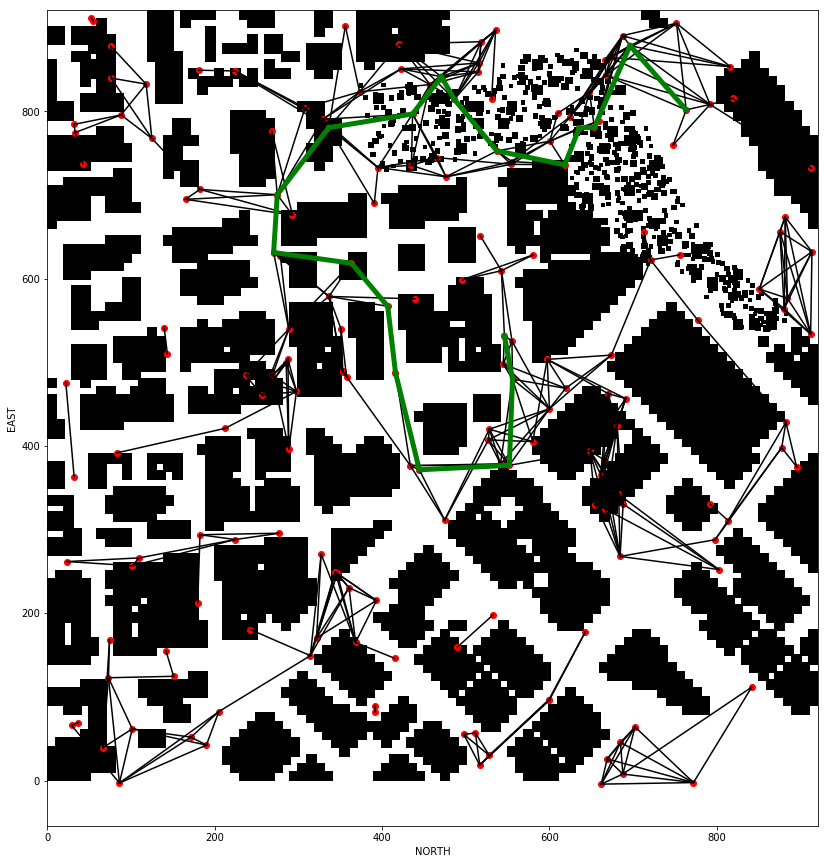

In [170]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

n_min=np.min(data[:,0])
e_min=np.min(data[:,1])

# Add code to visualize path here
path,path_cost=a_star(goal=goal,graph=result_graph,heuristic=heuristic,start=start)

print("Total path cost :",path_cost)

#plot the nodes
for node in result_graph.nodes:
    plt.scatter(node[1]-e_min,node[0]-n_min,c='red')
    
#plot the result graph edges
for (n1,n2) in np.array(result_graph.edges):
    plt.plot((n1[1]-e_min , n2[1]-e_min),(n1[0]-n_min,n2[0]-n_min),'black')

if (path is not None):
    for i in range(len(path)-1) :
        start_node=path[i]
        next_node=path[i+1]
        #in the plot x-east y-north
        plt.plot((start_node[1] - e_min , next_node[1] - e_min),(start_node[0]-n_min , next_node[0]-n_min),'green',linewidth=5)
    
    

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)